In [1]:
import cv2
import requests
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Step 1: Prepare the dataset with RGB values and corresponding color names
data = pd.read_csv('/content/colors_new.csv')

# Create DataFrame
df = pd.DataFrame(data)
print(df.head())

# Features (RGB values) and target labels (Color names)
y = df['Color']
print(y.head())
X = df.drop('Color', axis=1)
print(X.head())


                   Color    R    G    B
0   Air Force Blue (Raf)   93  138  168
1  Air Force Blue (Usaf)    0   48  143
2   Air Superiority Blue  114  160  193
3        Alabama Crimson  163   38   56
4             Alice Blue  240  248  255
0     Air Force Blue (Raf)
1    Air Force Blue (Usaf)
2     Air Superiority Blue
3          Alabama Crimson
4               Alice Blue
Name: Color, dtype: object
     R    G    B
0   93  138  168
1    0   48  143
2  114  160  193
3  163   38   56
4  240  248  255


In [3]:
# Scale RGB features to [0, 1] range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[0.36470588 0.54117647 0.65882353]
 [0.         0.18823529 0.56078431]
 [0.44705882 0.62745098 0.75686275]
 ...
 [0.99607843 0.99607843 0.2       ]
 [0.         0.07843137 0.65882353]
 [0.17254902 0.08627451 0.03137255]]


In [4]:
#Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#print(X_test)
y_pred=knn.predict(X_test)
#print(y_pred)

In [5]:
# Step 3: Function to detect the color from a specific pixel (x, y)

def detect_color_from_pixel(image, x, y):
    # Get the RGB value at the specified (x, y) coordinates in OpenCV BGR format
    pixel_color_bgr = image[y, x]  # Note that OpenCV uses (y, x) indexing
    # Convert from BGR to RGB
    pixel_color_rgb = pixel_color_bgr[::-1]

    print(f"Original RGB value at ({x}, {y}): {pixel_color_rgb}")

    # Scale the RGB value to the [0, 1] range to match the training data
    pixel_color_scaled = scaler.transform([pixel_color_rgb])

    # Use KNN to predict the color name
    predicted_color = knn.predict(pixel_color_scaled)
    print(f"The detected color is: {predicted_color[0]}")

In [6]:

# Step 4: Function to download and convert image from URL to OpenCV format
def get_image_from_url(image_url):
    try:
        # Download the image
        response = requests.get(image_url)

        # Check if the response is OK (200)
        if response.status_code == 200:
            # Check if the response content is actually an image
            content_type = response.headers['Content-Type']
            if 'image' not in content_type:
                print("Error: URL does not point to an image.")
                return None

            # Open the image using PIL
            img = Image.open(BytesIO(response.content))

            # Convert the image to RGB format and then to a NumPy array
            img = img.convert("RGB")
            img = np.array(img)

            # Convert the image from RGB to BGR (since OpenCV uses BGR format)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            return img
        else:
            print(f"Error: Unable to load image. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error loading image from URL: {e}")
        return None

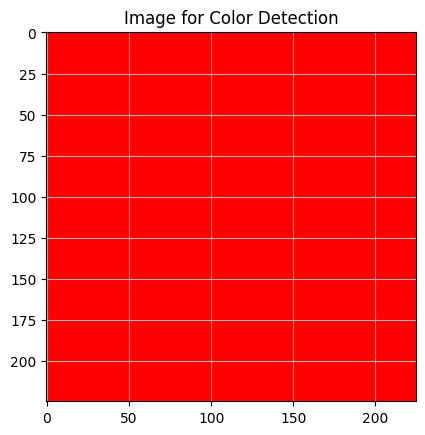

interactive(children=(IntSlider(value=0, description='x', max=224), IntSlider(value=0, description='y', max=22…

In [8]:

# Step 5: Display the image with matplotlib and allow user to input (x, y) coordinates
def main():
    # Provide an image URL here
    image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2bNLi-cruL8teuJy-HQ5lJTloeVC_TmN6Mg&s"

    # Get the image from the URL
    image = get_image_from_url(image_url)

    if image is None:
        print("Error loading image. Please check the URL.")
        return

    # Convert image from BGR (OpenCV format) to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(image_rgb)
    plt.title("Image for Color Detection")
    plt.grid(True)  # Display grid for easier region selection
    plt.show()

    # Step 6: Create an interactive function for user to specify x, y coordinates
    @interact(x=(0, image.shape[1]-1), y=(0, image.shape[0]-1))
    def select_pixel(x=0, y=0):
        print(f"Selected coordinates: x={x}, y={y}")
        detect_color_from_pixel(image, x, y)

if __name__ == "__main__":
    main()
